# Fine Tuning BERT in Python for Disaster Tweets Classification

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

Kaggle hosted a challenge named Real or Not whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about real disaster against the ones talking about it metaphorically.

# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

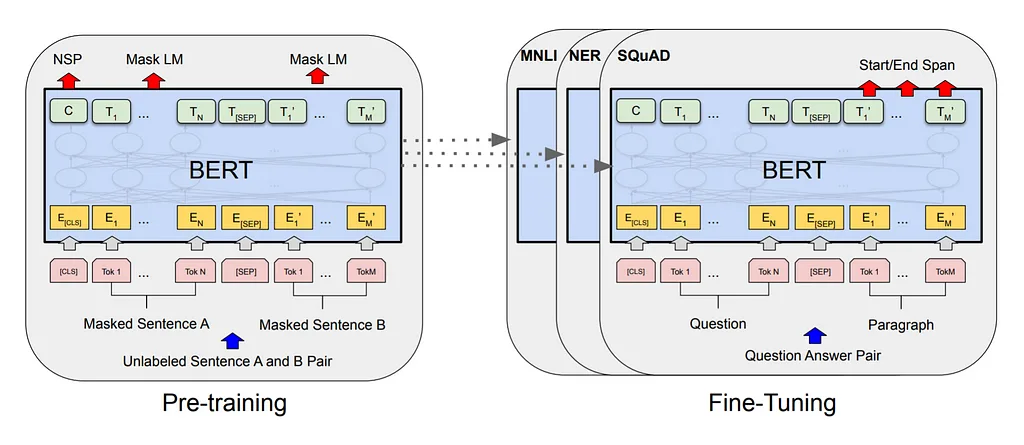

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Real or Not? Disaster Tweets Classifications

In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download Data

In [2]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [6]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

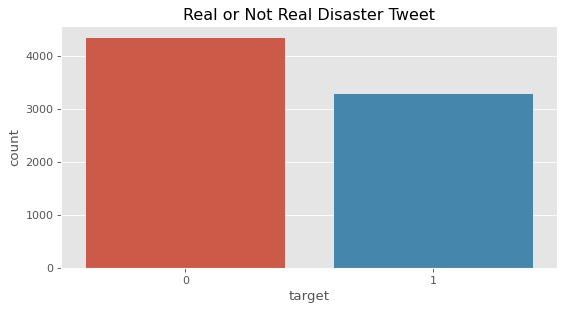

In [7]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [8]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

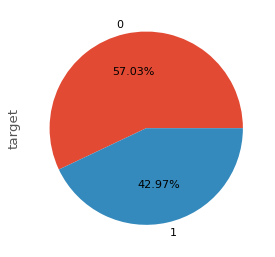

In [9]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [10]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-31qatq34
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-31qatq34
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.0-cp36-none-any.whl size=11716 sha256=03e0ffe70c352c1a40472ffdcfa0913c6017fdddf731712419810971f472b071
  Stored in directory: /tmp/pip-ephem-wheel-cache-sec9jkgx/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [11]:
import preprocess_kgptalkie as kgp

In [12]:
tweet = kgp.get_basic_features(tweet)

In [13]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


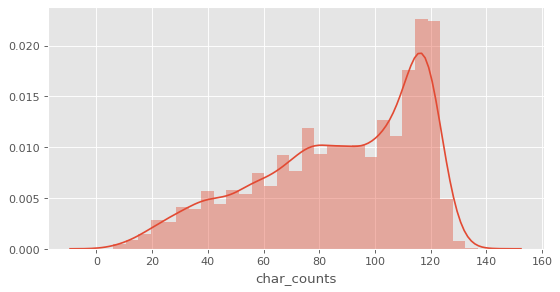

In [14]:
sns.distplot(tweet['char_counts'])

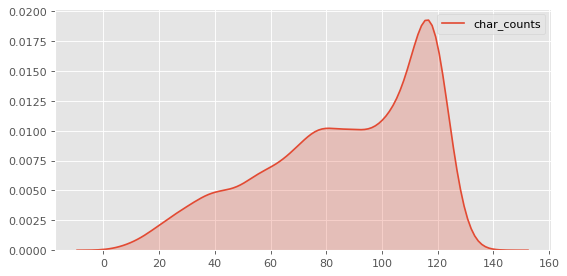

In [15]:
sns.kdeplot(tweet['char_counts'], shade=True)

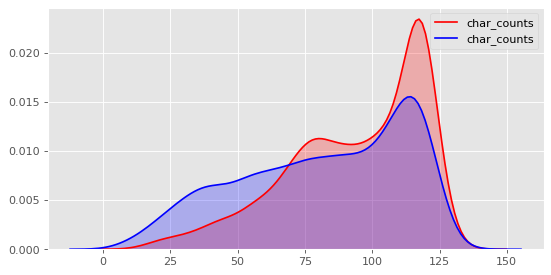

In [16]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

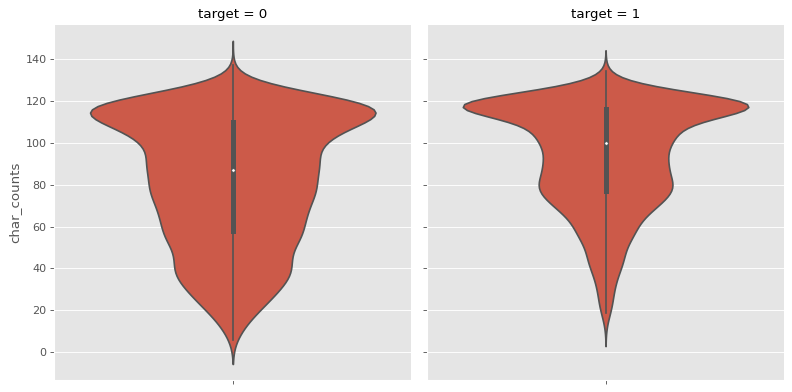

In [17]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

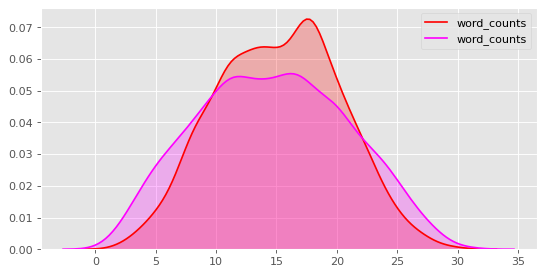

In [18]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


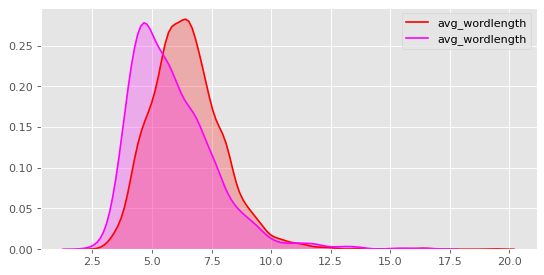

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


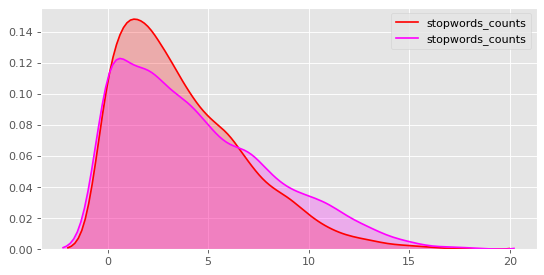

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [21]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [22]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [23]:
top20 = freqs[100:120]

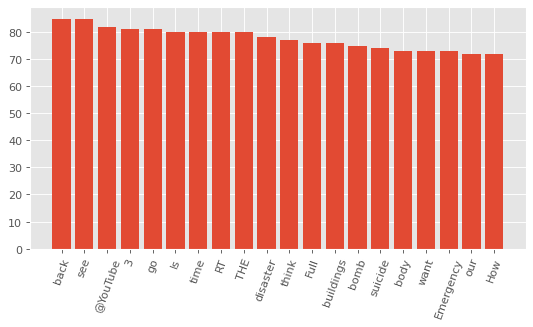

In [24]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [25]:
least20 = freqs[-20:]
least20

revealing                 1
68                        1
KY:                       1
object.                   1
#CLIMATE                  1
@95roots                  1
emergency?                1
suspects                  1
leather                   1
guns..                    1
http://t.co/RTUeTdfBqb    1
http://t.co/1EPIYeNQYL    1
http://t.co/KS7Ln8HQ8s    1
@dieanpink95              1
http://t.co/ML8IrhWg7O    1
WindstormåÊInsurer        1
http://t.co/fQWTSxLkrZ    1
@Gbay99                   1
friends.                  1
:-D                       1
dtype: int64

In [26]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [27]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

### One-Shot Data Cleaning

In [28]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [29]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [30]:
tweet.head()['text']

0    oyour deeds are the reason of this earetweethq...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evasee yoyouation...
4    jyoust got sent this photo from ryouby alaska ...
Name: text, dtype: object

In [31]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

### Disaster Words Visualization with Word Cloud



In [ ]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

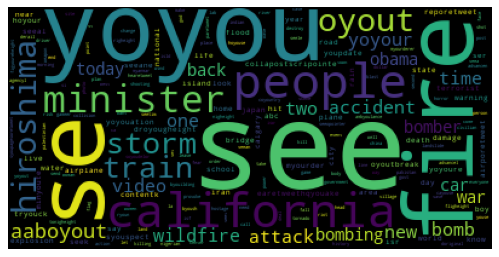

In [33]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

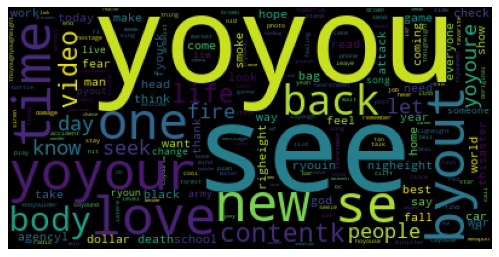

In [34]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [35]:
text = tweet['text']
y = tweet['target']

In [36]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [37]:
X.shape

(7613, 23333)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [39]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [40]:
from sklearn.svm import LinearSVC

In [41]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



## Classification with `Word2Vec` and SVM


In [42]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 54.4MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=e57f78b5c7fc9ad0cc482ce2a7f9b49636ca448e6618ed9b520cef34d64c2e36
  Stored in directory: /tmp/pip-ephem-wheel-cache-_05ejxhr/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [43]:
import spacy
import en_core_web_lg

In [44]:
nlp = en_core_web_lg.load()

In [45]:
x = 'cat dog'
doc = nlp(x)

In [46]:
doc.vector.shape

(300,)

In [47]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [48]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [49]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,oyour deeds are the reason of this earetweethq...,1,57,13,4.384615,6,1,0,0,1,"[-0.2098871, -0.007629695, -0.19607861, -0.163..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-0.00050089136, 0.023181401, -0.102390535, -0..."
3,6,NaN,NaN,130 people receive wildfires evasee yoyouation...,1,57,8,7.125000,1,1,0,1,0,"[-0.14550035, 0.21902388, 0.07671245, -0.14768..."
4,7,NaN,NaN,jyoust got sent this photo from ryouby alaska ...,1,72,16,4.500000,6,2,0,0,0,"[-0.0026213732, -0.01916919, -0.063435, 0.0685..."


In [50]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [51]:
X.shape

(7613, 1)

In [52]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [53]:
X.shape

(7613, 300)

In [54]:
y = tweet['target']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [56]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       869
           1       0.78      0.68      0.73       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

CPU times: user 2.79 s, sys: 25.8 ms, total: 2.81 s
Wall time: 2.81 s


## Word Embeddings and Classification with Deep Learning


In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [58]:
text

0       oyour deeds are the reason of this earetweethq...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evasee yoyouation...
4       jyoust got sent this photo from ryouby alaska ...
                              ...                        
7608    two giant cranes holding a bridge collapostscr...
7609    aria ahoyourary thetawnice to haveat isst the ...
7610    m1 94 0104 yocoordinated universal time5km s o...
7611    poli se investigating afeatyouringer an ebike ...
7612    the latest more homes razed by noretweethern c...
Name: text, Length: 7613, dtype: object

In [59]:
token = Tokenizer()
token.fit_on_texts(text)

In [60]:
vocab_size = len(token.word_index) + 1
vocab_size

23370

In [ ]:
print(token.word_index)

In [62]:
encoded_text = token.texts_to_sequences(text)

In [ ]:
print(encoded_text)

In [64]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [65]:
print(X)

[[ 129 4714   24 ...    0    0    0]
 [ 214   48  261 ...    0    0    0]
 [  45 1821 1455 ...    0    0    0]
 ...
 [2871 2451 4705 ...    0    0    0]
 [  74   42 1205 ...    0    0    0]
 [   2  239   59 ...    0    0    0]]


In [66]:
X.shape

(7613, 40)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [68]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


In [69]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2337000   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [71]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 6s 29ms/step - loss: 0.6429 - accuracy: 0.6330 - val_loss: 0.5614 - val_accuracy: 0.7603
Epoch 2/5
191/191 [==============================] - 5s 28ms/step - loss: 0.4755 - accuracy: 0.7915 - val_loss: 0.4626 - val_accuracy: 0.7945
Epoch 3/5
191/191 [==============================] - 5s 27ms/step - loss: 0.3527 - accuracy: 0.8565 - val_loss: 0.4587 - val_accuracy: 0.7879
Epoch 4/5
191/191 [==============================] - 5s 27ms/step - loss: 0.2304 - accuracy: 0.9140 - val_loss: 0.4957 - val_accuracy: 0.7846
Epoch 5/5
191/191 [==============================] - 5s 28ms/step - loss: 0.1513 - accuracy: 0.9440 - val_loss: 0.5552 - val_accuracy: 0.7735
CPU times: user 42.3 s, sys: 2.8 s, total: 45.1 s
Wall time: 33.8 s


In [72]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [73]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [74]:
vec

array([[ 6, 35,  4, 13, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [75]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# BERT Model Building and Training

In [ ]:
!pip install ktrain

In [77]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,oyour deeds are the reason of this earetweethq...,1,57,13,4.384615,6,1,0,0,1,"[-0.2098871, -0.007629695, -0.19607861, -0.163..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-0.00050089136, 0.023181401, -0.102390535, -0..."
3,6,NaN,NaN,130 people receive wildfires evasee yoyouation...,1,57,8,7.125000,1,1,0,1,0,"[-0.14550035, 0.21902388, 0.07671245, -0.14768..."
4,7,NaN,NaN,jyoust got sent this photo from ryouby alaska ...,1,72,16,4.500000,6,2,0,0,0,"[-0.0026213732, -0.01916919, -0.063435, 0.0685..."


In [78]:
from ktrain import text
import ktrain

In [79]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [80]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [81]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [82]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 137s 1s/step - loss: 0.5450 - accuracy: 0.7205 - val_loss: 0.4410 - val_accuracy: 0.7966


In [83]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 133s 1s/step - loss: 0.4133 - accuracy: 0.8174 - val_loss: 0.4253 - val_accuracy: 0.8333
Epoch 2/3
108/108 [==============================] - 134s 1s/step - loss: 0.3645 - accuracy: 0.8470 - val_loss: 0.4137 - val_accuracy: 0.8386
Epoch 3/3
108/108 [==============================] - 133s 1s/step - loss: 0.2620 - accuracy: 0.8921 - val_loss: 0.4508 - val_accuracy: 0.8425


In [84]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 133s 1s/step - loss: 0.3352 - accuracy: 0.8590 - val_loss: 0.4615 - val_accuracy: 0.8228
Epoch 2/3
108/108 [==============================] - 133s 1s/step - loss: 0.3115 - accuracy: 0.8748 - val_loss: 0.5920 - val_accuracy: 0.7480
Epoch 3/3
108/108 [==============================] - 133s 1s/step - loss: 0.1731 - accuracy: 0.9365 - val_loss: 0.5802 - val_accuracy: 0.8346


In [ ]:
# find out best learning rate?
# learner.lr_find()
# learner.lr_plot()

# it may take days or many days to find out.

In [85]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [86]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [87]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:209: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


array([[0.9929716 , 0.00702845],
       [0.48570436, 0.51429564]], dtype=float32)

In [90]:
predictor.predict(data[1])

'target'

In [93]:
classes = predictor.get_classes()

In [95]:
data

['i met you today by accident', 'i got today car accident, i am injured']

In [94]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [92]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)